# Yeast G-Protein Cycle
***
In budding yeast, and and extra cellular pheromone gradient causes a polarization.  The ligand particles of the pheromone gradient bind with receptors (R) on the cell membrane to form a complex (RL), which actives the G-Protein complex (G), splitting it into alpha (Ga) and beta-gamma (Gbg) subunits. The alpha subunit deactivates (Gd) and can then rebind with a beta-gamma subunit to reform the complex.
Using the axial symmetry of the yeast cell geometry, we model the cell membrane as a circle.  This can be represented as a 1D periodic domain from -2*pi to 2*pi.  We use a DataFunction object to represent the pheromone gradient as a spatially varying function.
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
import math
import numpy

MatPlotLib is used for creating custom visualizations

In [3]:
import matplotlib.pyplot as plt

In [4]:
import spatialpy

***
## Create the Data Functions for the System
***

In [5]:
class PheromoneGradient(spatialpy.DataFunction):
    def __init__(self, a=0.0, b=1.0, L_min=0, L_max=4, MOLAR=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="PheromoneGradient")
        self.a = a
        self.b = b
        self.L_min = L_min
        self.L_max = L_max
        self.MOLAR = MOLAR

    def expression(self):
        return f"({(self.L_max - self.L_min) * 0.5} * (1 + cos(0.5 * me->x[0])) + {self.L_min}) * {self.MOLAR}"
    
    def map(self, x): #for visualization
        return ((self.L_max - self.L_min) * 0.5 * (1 + math.cos(0.5 * x[0])) + self.L_min) * self.MOLAR

***
## Create G-Protein Cycle 1D Model
***

In [6]:
def create_g_protein(model_name="G_protein_cycle_1D", parameter_values=None):
    # Initialize Model
    model = spatialpy.Model(model_name)
    
    # System constants
    L = 4 * 3.14159
    NUM_VOXELS = 200
    MOLAR = 6.02e-01 * ((L / NUM_VOXELS) ** 3)

    # Define Domain
    domain = spatialpy.Domain.create_2D_domain(
        numy=1, numx=NUM_VOXELS, xlim=(-2 * numpy.pi, 2 * numpy.pi), ylim=(0, 1)
    )
    
    # Set Models Domain
    model.add_domain(domain)

    # Define Variables (SpatialPy.Species)
    R = spatialpy.Species(name="R", diffusion_coefficient=0.01)
    RL = spatialpy.Species(name="RL", diffusion_coefficient=0.01)
    G = spatialpy.Species(name="G", diffusion_coefficient=0.01)
    Ga = spatialpy.Species(name="Ga", diffusion_coefficient=0.01)
    Gbg = spatialpy.Species(name="Gbg",diffusion_coefficient=0.01)
    Gd = spatialpy.Species(name="Gd", diffusion_coefficient=0.01)
    
    # Add Variables to Model
    model.add_species([R, RL, G, Ga, Gbg, Gd])

    # Define Initial Conditions
    # Distribute molecules randomly over the mesh according to their initial values
    R_ic = spatialpy.ScatterInitialCondition(R, 10000)
    G_ic = spatialpy.ScatterInitialCondition(G, 10000)
    
    # Add Initial Conditions to Model
    model.add_initial_condition([R_ic, G_ic])

    # Define Parameters
    SA = spatialpy.Parameter(name="SA", expression=201.056)
    V = spatialpy.Parameter(name="V", expression=33.5)
    k_RL = spatialpy.Parameter(name="k_RL", expression=2e-03 / MOLAR)
    k_RLm = spatialpy.Parameter(name="k_RLm", expression=1e-02)
    k_Rs = spatialpy.Parameter(name="k_Rs", expression="4.0 / SA")
    k_Rd0 = spatialpy.Parameter(name="k_Rd0", expression=4e-04)
    k_Rd1 = spatialpy.Parameter(name="k_Rd1", expression=4e-04)
    k_G1 = spatialpy.Parameter(name="k_G1", expression="1.0 * SA")
    k_Ga = spatialpy.Parameter(name="k_Ga", expression="1e-06 * SA")
    k_Gd = spatialpy.Parameter(name="k_Gd", expression=0.1)
    
    # Add Parameters to Model
    model.add_parameter([SA, V, k_RL, k_RLm, k_Rs, k_Rd0, k_Rd1, k_G1, k_Ga, k_Gd]) 

    # Define Reactions
    R0 = spatialpy.Reaction(name="R0", reactants={}, products={'R': 1}, rate='k_Rs')
    R1 = spatialpy.Reaction(name="R1", reactants={'R': 1}, products={}, rate='k_Rd0')
    R2 = spatialpy.Reaction(
        name="R2", reactants={'R': 1}, products={'RL': 1},
        propensity_function="k_RL * R * PheromoneGradient / vol"
    )
    R3 = spatialpy.Reaction(name="R3", reactants={'RL': 1}, products={'R': 1}, rate='k_RLm')
    R4 = spatialpy.Reaction(name="R4", reactants={'RL': 1}, products={}, rate='k_RLm')
    R5 = spatialpy.Reaction(
        name="R5", reactants={'G': 1}, products={'Ga': 1, 'Gbg': 1},
        propensity_function="k_Ga * RL * G / vol"
    )
    R6 = spatialpy.Reaction(name="R6", reactants={'Ga': 1}, products={'Gd': 1}, rate='k_Ga')
    R7 = spatialpy.Reaction(name="R7", reactants={'Gd': 1, 'Gbg': 1}, products={'G': 1}, rate='k_G1')
    
    # Add Reactions to Model
    model.add_reaction([R0, R1, R2, R3, R4, R5, R6, R7])

    # Define Data Functions
    # mating pheromone gradient
    pheromone_grad = PheromoneGradient(a=-2 * 3.14159, b=2 * 3.14159, MOLAR=MOLAR)
    
    # Add Data Function to Model
    model.add_data_function(pheromone_grad)

    # Define Timespan
    tspan = spatialpy.TimeSpan(range(11))
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Instantiate the Model

In [7]:
model = create_g_protein()

(-6.283185307179586, 6.283185307179586) (0, 1)
[-6.28318531 -6.22003772 -6.15689013 -6.09374253 -6.03059494 -5.96744735
 -5.90429976 -5.84115217 -5.77800458 -5.71485699 -5.6517094  -5.58856181
 -5.52541421 -5.46226662 -5.39911903 -5.33597144 -5.27282385 -5.20967626
 -5.14652867 -5.08338108 -5.02023349 -4.9570859  -4.8939383  -4.83079071
 -4.76764312 -4.70449553 -4.64134794 -4.57820035 -4.51505276 -4.45190517
 -4.38875758 -4.32560999 -4.26246239 -4.1993148  -4.13616721 -4.07301962
 -4.00987203 -3.94672444 -3.88357685 -3.82042926 -3.75728167 -3.69413408
 -3.63098648 -3.56783889 -3.5046913  -3.44154371 -3.37839612 -3.31524853
 -3.25210094 -3.18895335 -3.12580576 -3.06265816 -2.99951057 -2.93636298
 -2.87321539 -2.8100678  -2.74692021 -2.68377262 -2.62062503 -2.55747744
 -2.49432985 -2.43118225 -2.36803466 -2.30488707 -2.24173948 -2.17859189
 -2.1154443  -2.05229671 -1.98914912 -1.92600153 -1.86285394 -1.79970634
 -1.73655875 -1.67341116 -1.61026357 -1.54711598 -1.48396839 -1.4208208
 -1.3

***
## Run the Simulation
***

In [8]:
%time result = model.run()

CPU times: user 34.7 ms, sys: 9.22 ms, total: 43.9 ms
Wall time: 18.4 s


***
## Visualizations
***

In [9]:
def plot(sname):
    x_vals = model.domain.coordinates()[:,0]
    
    tspan_len = len(model.tspan)
    num_rows = math.ceil(tspan_len/2)
    fig, axs = plt.subplots(num_rows, 2, figsize=[15, 6 * num_rows])
    if tspan_len%2 != 0:
        fig.delaxes(axs[num_rows - 1, 1])
    
    for n, t in enumerate(model.tspan):
        S = result.get_species(sname, timepoints=n)
        axs[int(n/2), n%2].plot(x_vals, S)
        axs[int(n/2), n%2].set_title(f'{t}   t={sname}')

In [10]:
def plot_timepoint(sname, n):
    x_vals = model.domain.coordinates()[:,0]
    S = result.get_species(sname, timepoints=n)
    
    plt.plot(x_vals, S)
    plt.title(f'{n}   t={sname}')

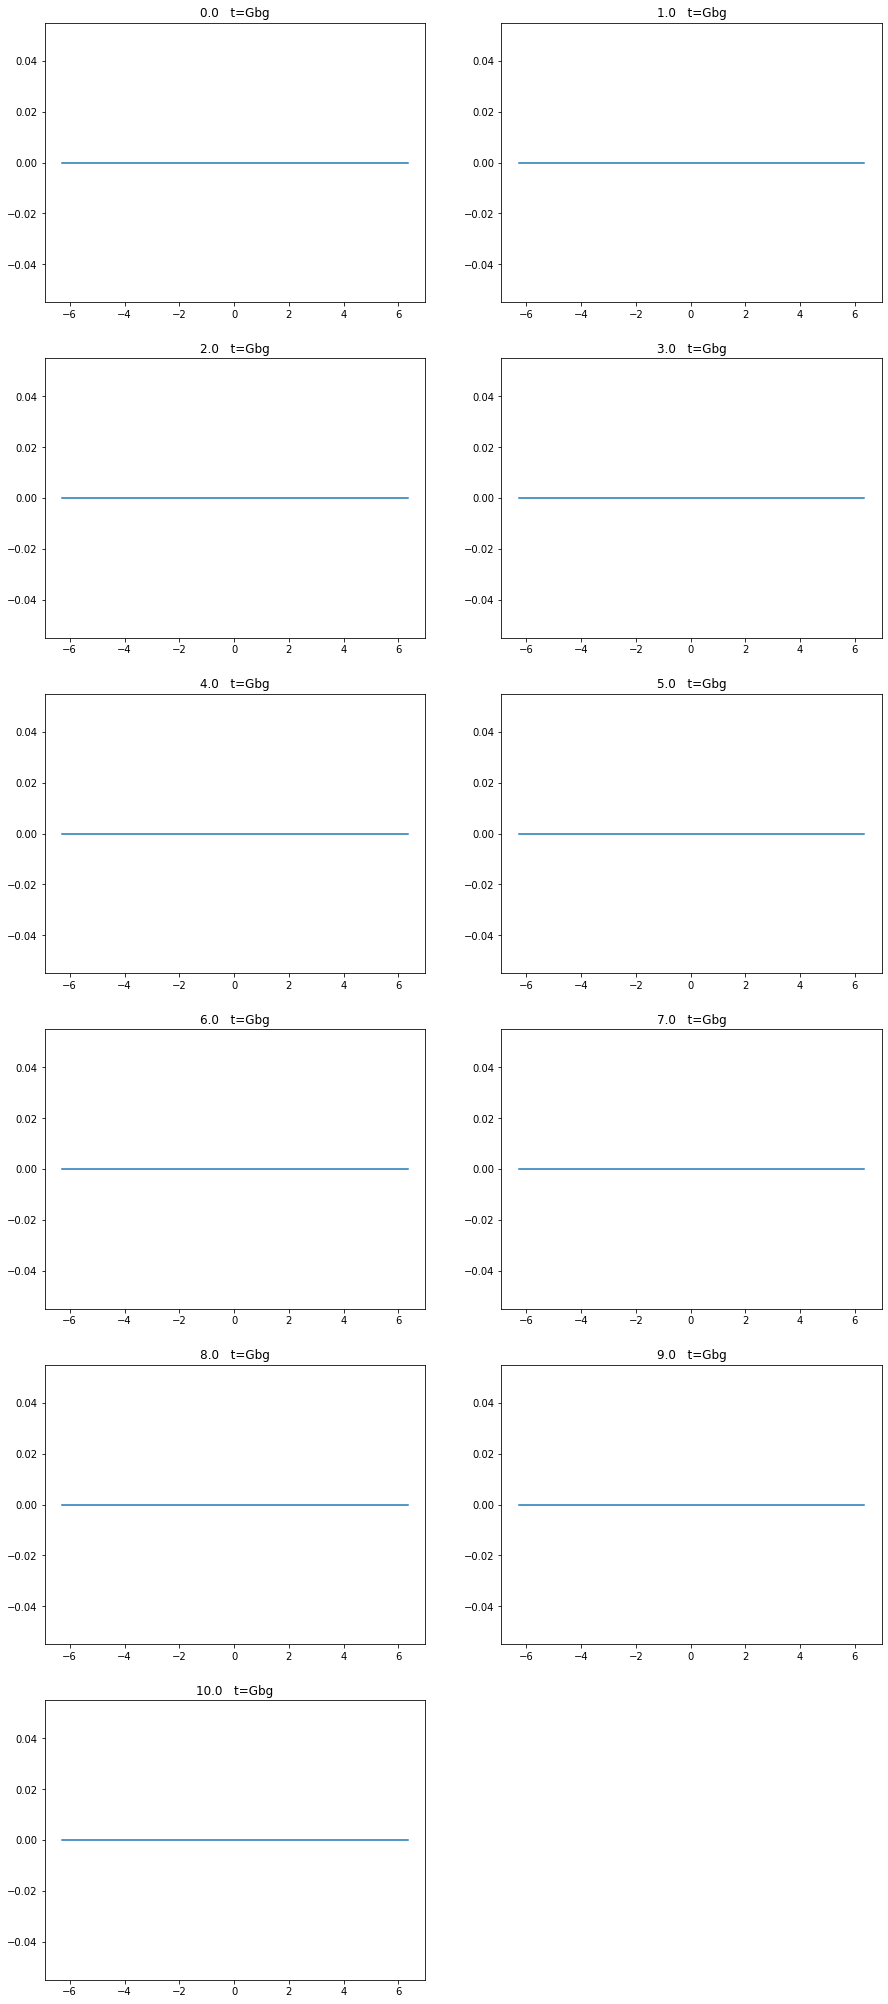

In [11]:
plot("Gbg")

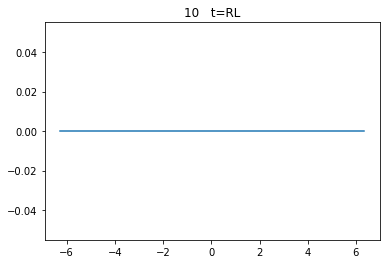

In [12]:
plot_timepoint("RL", 10)

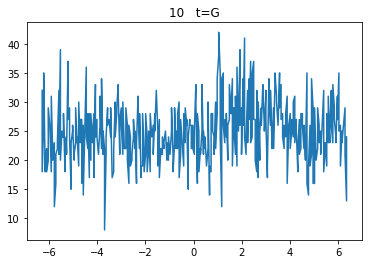

In [13]:
plot_timepoint("G", 10)

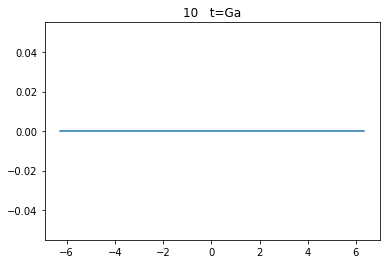

In [14]:
plot_timepoint("Ga", 10)

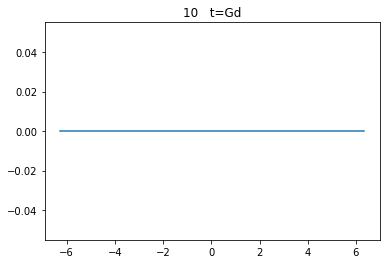

In [15]:
plot_timepoint("Gd", 10)

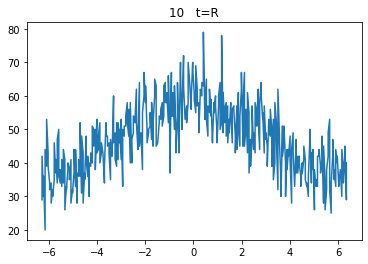

In [16]:
plot_timepoint("R", 10)

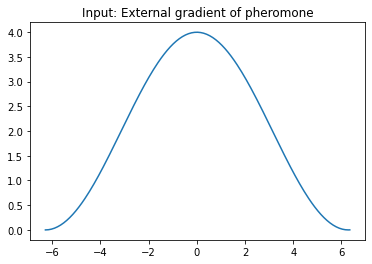

In [17]:
L = 4*3.14159
NUM_VOXEL = 200
MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
x_vals = model.domain.coordinates()[:, 0]
pg = PheromoneGradient()
gradient = [pg.map([x]) for x in x_vals]
plt.plot(x_vals, gradient)
_ = plt.title('Input: External gradient of pheromone')